In [10]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

# Load Dataset

In [3]:
x_train = np.load('dataset/x_train.npy').astype(np.float32)
y_train = np.load('dataset/y_train.npy').astype(np.float32)
x_val = np.load('dataset/x_val.npy').astype(np.float32)
y_val = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


# Preview

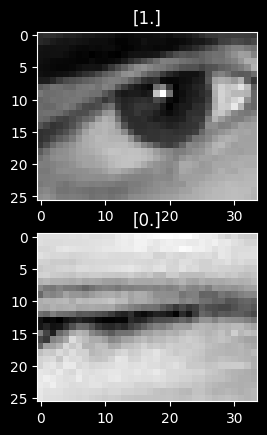

In [4]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

# Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [6]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26, 34, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 34, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,129 (3.36 MB)

 Trainable params: 880,129 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [11]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.keras' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)


Epoch 1/50


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6610 - loss: 0.5804
Epoch 1: val_acc improved from -inf to 0.89236, saving model to models/2024_07_17_23_21_55.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - acc: 0.6647 - loss: 0.5764 - val_acc: 0.8924 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 2/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9019 - loss: 0.2656
Epoch 2: val_acc improved from 0.89236 to 0.95486, saving model to models/2024_07_17_23_21_55.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.9022 - loss: 0.2650 - val_acc: 0.9549 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 3/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.9359 - loss: 0.1948
Epoch 3: val_acc did not improve from 0.95486
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.9358 - loss: 0.1947 - val_acc: 0.9549 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9440 - loss: 0.1576
Epoch 4: val_acc improved from 0.95486 to 0.97917, saving 

# Confusion Matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
test acc: 0.9965277777777778


<Axes: >

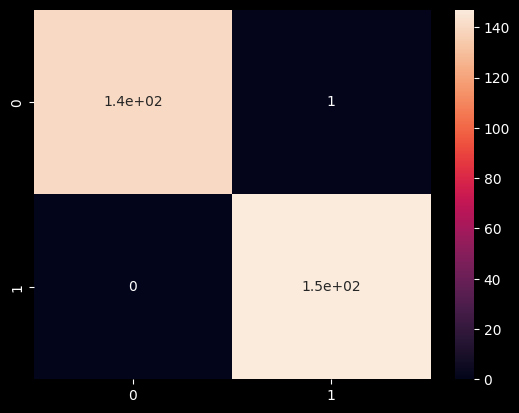

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.keras' % (start_time), compile=False)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
y_pred = model.predict(x_val/255)
y_pred_logical = (y_pred > 0.5).astype(np.int_)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

# Distribution of Prediction

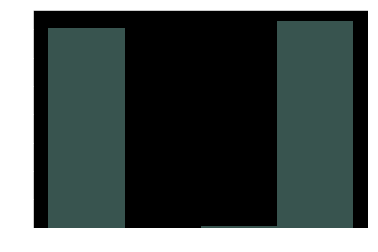

In [9]:
ax = sns.distplot(y_pred, kde=False)